<font size=5>**Turbofan engine Remaining Useful Lifetime prediction**</font>

![](../reports/figures/turbo.png)
![](../reports/figures/turbofan_schema.png)

In [1]:
import glob
import numpy as np # scientifique computation
import pandas as pd # data manipulation
from matplotlib import pyplot as plt # dataviz
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

# split dataset & prepare 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline

# ML model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# DL model
from sklearn.neural_network import MLPRegressor

# metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
path_to_processed_train = '../data/processed/train/'
files = sorted(glob.glob(path_to_processed_train+'*'))

# upload dataset
df = pd.read_csv(files[0])

# choose relevant features
to_drop = ['unit_id', 'time_cycle', 'max_cycle'] # id/label cols
cst_features = ['op_set_3', 'sensor_18', 'sensor_19'] # constant features
quasi_cst_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16'] # quiasi-constant features
correlated_feature = ['sensor_14, sensor_9']

# keep the ones to use for ML
cols_to_keep = [x for x in df.columns if x not in cst_features+quasi_cst_features+to_drop]

In [3]:
files

['../data/processed/train/FD001_processed.csv',
 '../data/processed/train/FD002_processed.csv',
 '../data/processed/train/FD003_processed.csv',
 '../data/processed/train/FD004_processed.csv']

In [4]:
df

,unit_id,time_cycle,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,1


In [5]:
# assign target and features
y = df['RUL']
X = df[cols_to_keep[:-1]]

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16504, 16) (4127, 16)
(16504,) (4127,)


In [6]:
def predict_y_RUL(pipe):
    # predict
    y_pred = pipe.predict(X_test)
    y_test.reset_index(drop=True)

    # create RUL df to compute error,d and score,s
    RUL = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=True )
    RUL.rename(columns={0:'true', 1:'estimated'}, inplace=True)

    # cast as int
    RUL['estimated'] = [int(i) for i in RUL['estimated']]

    # compute error d
    RUL['error'] = RUL['estimated'] - RUL['true']
    
    return RUL

In [7]:
# plot rul true vs estimated
def plot_rul_true_estimated(RUL):
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=RUL, x='true', y='estimated')
    plt.xlim(-50,350)
    plt.ylim(-50,350)
    plt.grid()
    plt.show()

### Benchmark - Linear regression

In [38]:
steps_lr = [('polynomial', PolynomialFeatures(2, interaction_only=True)),
            ('scaler', StandardScaler()),
             ('estimator', LinearRegression())]

pipe_lr = Pipeline(steps=steps_lr)

In [39]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(interaction_only=True)),
                ('scaler', StandardScaler()),
                ('estimator', LinearRegression())])

In [40]:
pipe_lr.score(X_test, y_test)

0.6182173542911361

In [41]:
predict_y_RUL(pipe=pipe_lr)

,true,estimated,error
0,169,158,-11
1,112,68,-44
2,151,152,1
3,89,118,29
4,87,95,8
...,...,...,...
4122,29,22,-7
4123,32,48,16
4124,166,158,-8
4125,143,113,-30


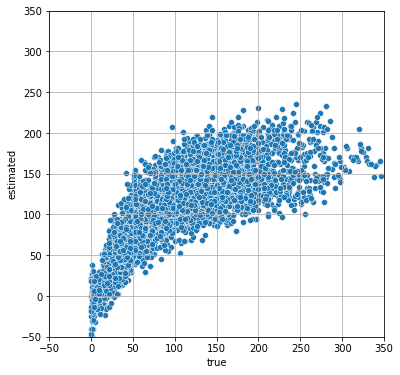

In [42]:
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_lr))

### Pipeline - Support vector machine

In [13]:
steps_svr = [('scaler', StandardScaler()),
            ('estimator', SVR())]

pipe_svr = Pipeline(steps=steps_svr)

In [14]:
pipe_svr.fit(X_train, y_train)
pipe_svr.score(X_test, y_test)

0.6116387533805021

In [15]:
predict_y_RUL(pipe=pipe_svr)

,true,estimated,error
0,169,152,-17
1,112,55,-57
2,151,133,-18
3,89,125,36
4,87,92,5
...,...,...,...
4122,29,32,3
4123,32,45,13
4124,166,157,-9
4125,143,111,-32


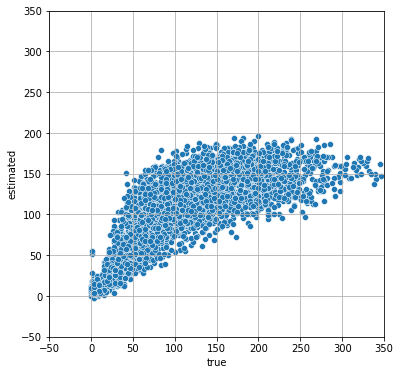

In [16]:
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_svr))

### Pipeline - Multi-layer Perceptron

In [44]:
steps_mlp = [('scaler', StandardScaler()),
            ('estimator', MLPRegressor(hidden_layer_sizes=(100,100), activation='tanh'))]

pipe_mlp = Pipeline(steps=steps_mlp)

In [45]:
pipe_mlp.fit(X_train, y_train)
pipe_mlp.score(X_test, y_test)

/home/hazmilh/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6358035507120476

In [46]:
predict_y_RUL(pipe=pipe_mlp)

,true,estimated,error
0,169,152,-17
1,112,52,-60
2,151,150,-1
3,89,132,43
4,87,94,7
...,...,...,...
4122,29,32,3
4123,32,45,13
4124,166,151,-15
4125,143,118,-25


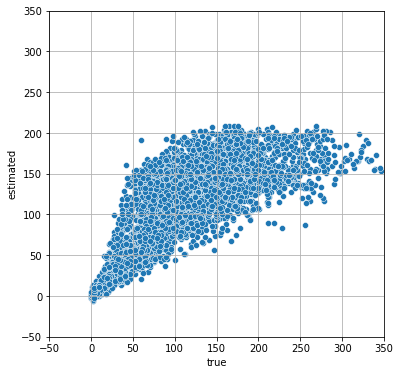

In [47]:
plot_rul_true_estimated(RUL=predict_y_RUL(pipe=pipe_mlp))

### Score comparisons

In [43]:
print(f'R² linear regression : {pipe_lr.score(X_test, y_test)}')
print(f'R² SVR               : {pipe_svr.score(X_test, y_test)}')
print(f'R² MLP               : {pipe_mlp.score(X_test, y_test)}')

R² linear regression : 0.6182173542911361
R² SVR               : 0.6116387533805021
R² MLP               : 0.6391792279565478


In [51]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('polynomial', PolynomialFeatures(interaction_only=True)),
  ('scaler', StandardScaler()),
  ('estimator', LinearRegression())],
 'verbose': False,
 'polynomial': PolynomialFeatures(interaction_only=True),
 'scaler': StandardScaler(),
 'estimator': LinearRegression(),
 'polynomial__degree': 2,
 'polynomial__include_bias': True,
 'polynomial__interaction_only': True,
 'polynomial__order': 'C',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__normalize': False}

In [50]:
pipe_svr.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('estimator', SVR())],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': SVR(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False}

In [48]:
pipe_mlp.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('estimator',
   MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 100)))],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 100)),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__activation': 'tanh',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 'auto',
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': (100, 100),
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.001,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 200,
 'estimator__momentum': 0.9,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__solver': 'adam',
 'estimator__tol': 0